# HSCT survival linear regression model

## Notebook set-up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

retrain_models=True
model_file='./models/01.3-linear_regression_stepwise.pkl'

## 1. Load data

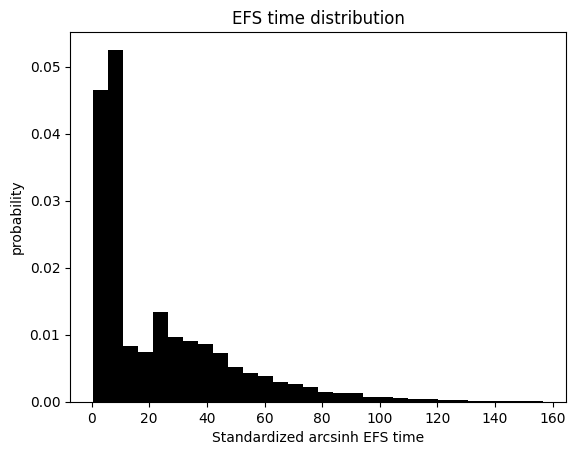

Training features: (28800, 178)


In [2]:
training_features_df=pd.read_parquet('./data/encoded/training_features_df.parquet')
training_labels_df=pd.read_parquet('./data/encoded/training_labels_df.parquet')
dictionary_df=pd.read_csv('./data/raw/data_dictionary.csv')

# Remove id column from training features
training_features_df.drop('ID', axis=1, inplace=True)

plt.title('EFS time distribution')
plt.hist(training_labels_df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('Standardized arcsinh EFS time')
plt.ylabel('probability')
plt.show()

print(f'Training features: {training_features_df.shape}')

## 2. Extract numerical features

In [3]:
# Get lists of numerical feature names
numerical_feature_names=dictionary_df['variable'][dictionary_df['type'] == 'Numerical']

# Remove the label column from the column names list
numerical_feature_names=numerical_feature_names[numerical_feature_names != 'efs_time']

# Get just the numerical features
training_features_df=training_features_df[numerical_feature_names]

print(f'Training numerical features: {training_features_df.shape}')
training_features_df.describe().transpose()

Training numerical features: (28800, 22)


,count,mean,std,min,25%,50%,75%,max
hla_match_c_high,28800.0,1.768044,0.414674,0.000,1.666667,2.000,2.00000,2.000
hla_high_res_8,28800.0,6.888993,1.509560,2.000,6.000000,8.000,8.00000,8.000
hla_low_res_6,28800.0,5.159329,1.168078,2.000,4.000000,6.000,6.00000,6.000
hla_high_res_6,28800.0,5.120058,1.170989,0.000,4.000000,6.000,6.00000,6.000
hla_high_res_10,28800.0,8.642674,1.833638,3.000,7.333333,10.000,10.00000,10.000
hla_match_dqb1_high,28800.0,1.745451,0.425752,0.000,1.666667,2.000,2.00000,2.000
hla_nmdp_6,28800.0,5.176991,1.157584,2.000,5.000000,6.000,6.00000,6.000
hla_match_c_low,28800.0,1.761898,0.422354,0.000,1.666667,2.000,2.00000,2.000
hla_match_drb1_low,28800.0,1.718646,0.438469,1.000,1.000000,2.000,2.00000,2.000
hla_match_dqb1_low,28800.0,1.780324,0.407639,0.000,2.000000,2.000,2.00000,2.000


## 3. Feature-label correlation plots

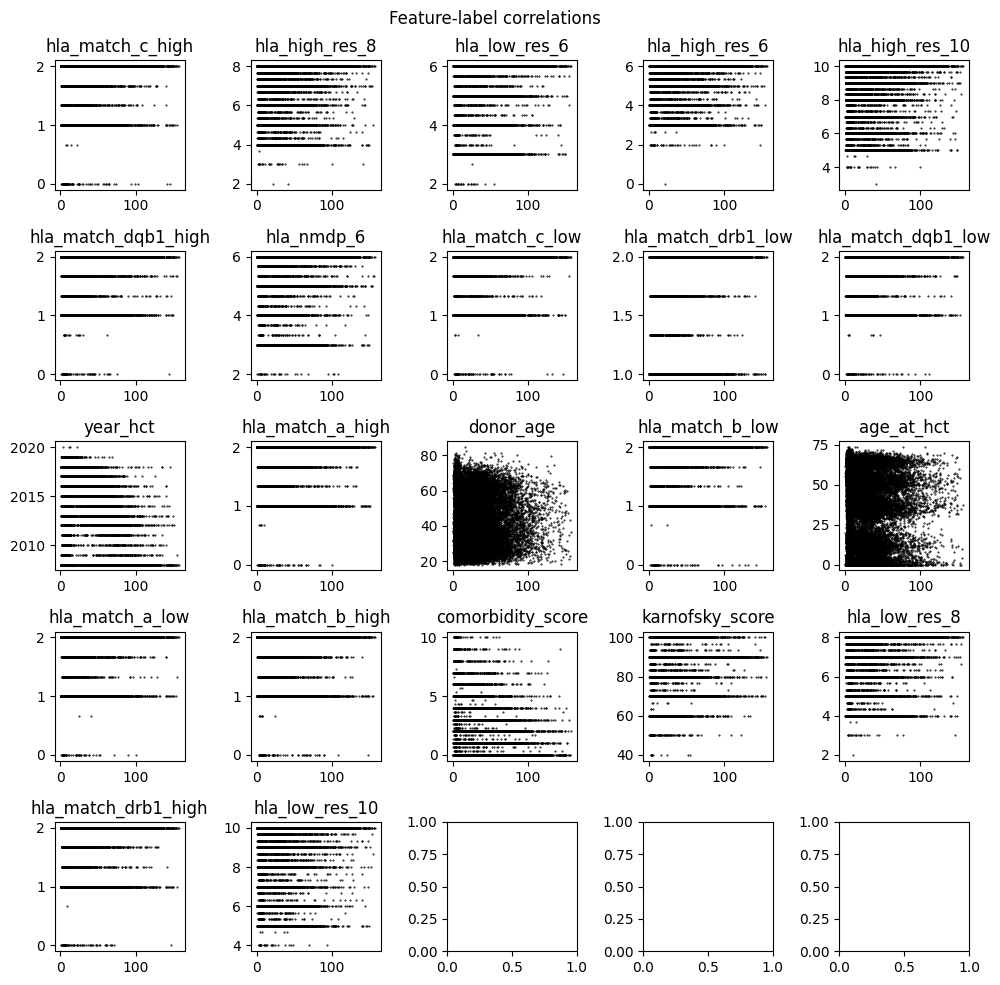

In [4]:
# Set-up a 5x5 figure
fig, axs=plt.subplots(5,5, figsize=(10,10))
axs=axs.flatten()

fig.suptitle('Feature-label correlations')

# Plot each feature
for ax, feature in zip(axs, training_features_df.columns):
    ax.set_title(feature)
    ax.scatter(training_labels_df['efs_time'], training_features_df[feature], color='black', s=0.2)

plt.tight_layout()
plt.show()

## 4. Models

### 4.1. *efs_time* ~ *donor_age*

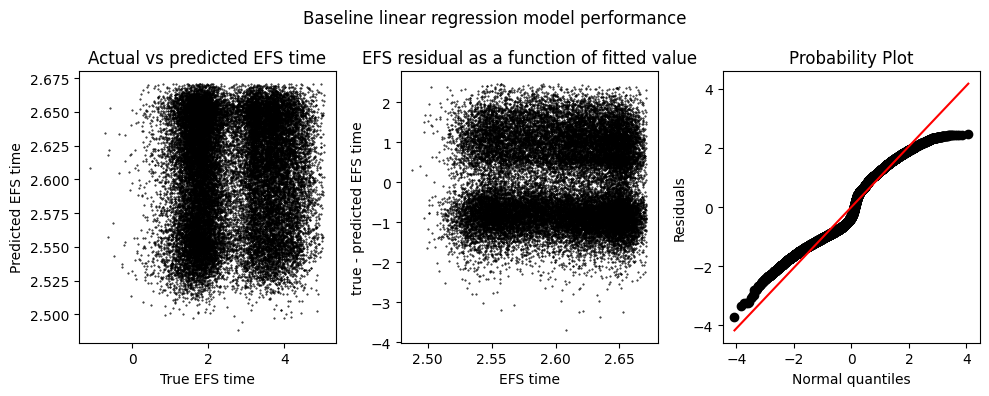

In [18]:
# Instantiate and fit the model
model=LinearRegression()

# Format the features
features=training_features_df['donor_age']

# Get the labels
efs_time=np.log(training_labels_df['efs_time'])

# Fit the model
model.fit(np.array(features).reshape(-1, 1),efs_time)

# Make predictions on the test data
predictions=model.predict(np.array(features).reshape(-1, 1))

# Plot the results
fig, axs=plt.subplots(1,3, figsize=(10,4))
axs=axs.flatten()

fig.suptitle('Baseline linear regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(efs_time, predictions, color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS residual as a function of fitted value')
axs[1].scatter(predictions, efs_time - predictions, color='black', s=0.2)
axs[1].set_xlabel('EFS time')
axs[1].set_ylabel('true - predicted EFS time')

axs[2].set_title('Normal quantile plot')
stats.probplot(efs_time - predictions, plot=axs[2])
axs[2].get_lines()[0].set_markeredgecolor('black')
axs[2].get_lines()[0].set_markerfacecolor('black')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

### 4.2. Evaluate other features

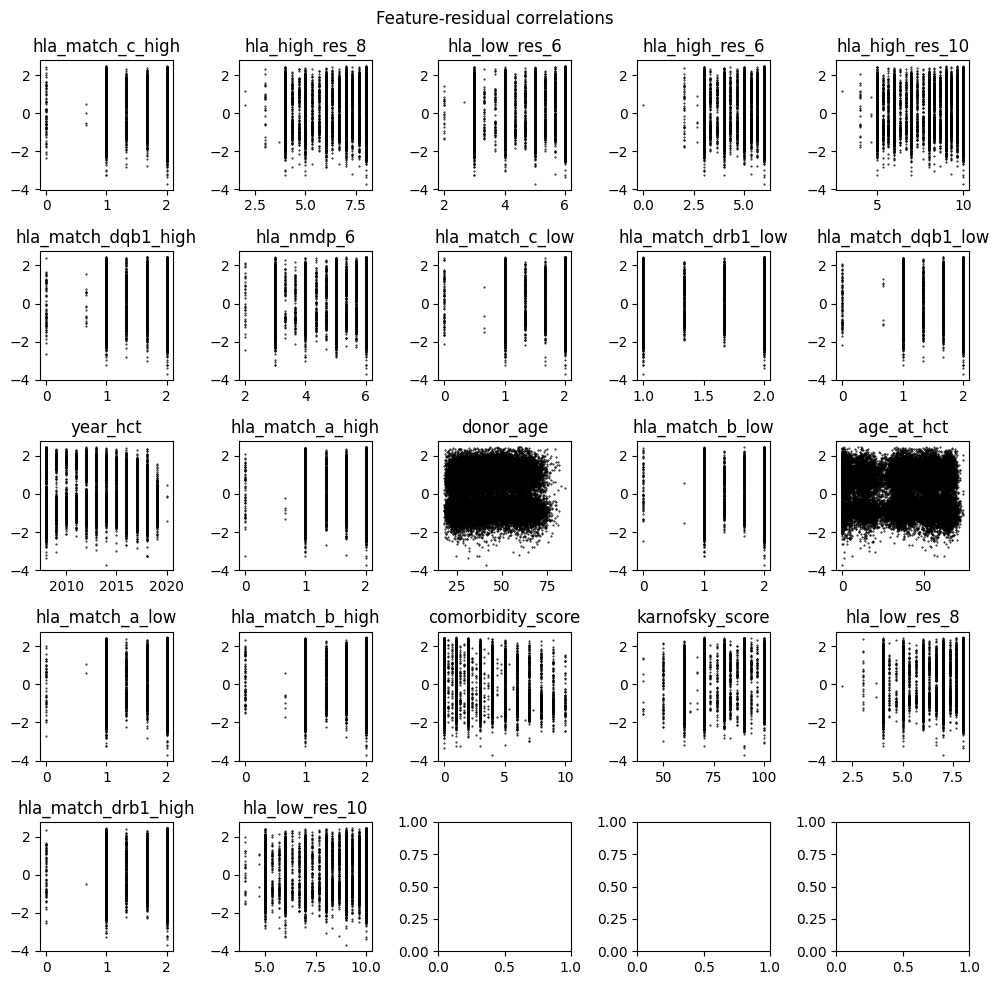

In [19]:
# Set-up a 5x5 figure
fig, axs=plt.subplots(5,5, figsize=(10,10))
axs=axs.flatten()

fig.suptitle('Feature-residual correlations')

# Plot each feature
for ax, feature in zip(axs, training_features_df.columns):
    ax.set_title(feature)
    ax.scatter(training_features_df[feature], efs_time - predictions, color='black', s=0.2)

plt.tight_layout()
plt.show()

### 4.3. *efs_time* ~ [*donor_age*, *age_at_hct*]

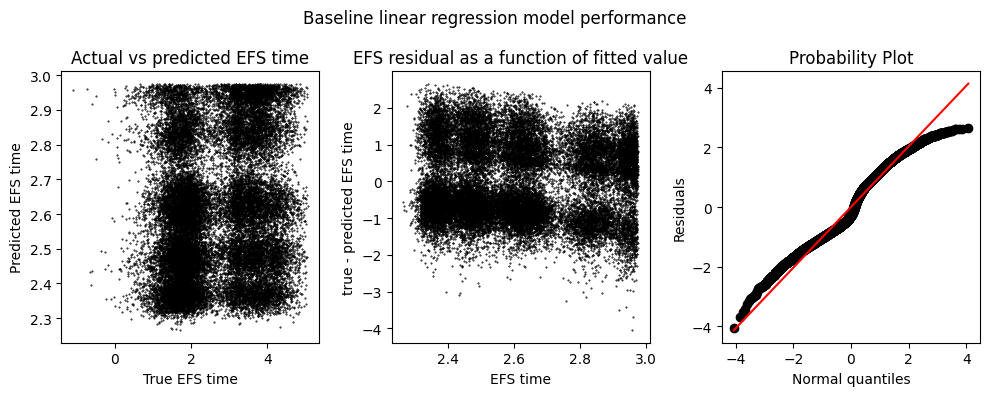

In [63]:
# Instantiate and fit the model
model=LinearRegression()

# Format the features
features=training_features_df[['donor_age','age_at_hct']].copy()

# Get the labels
efs_time=np.log(training_labels_df['efs_time'])

# Fit the model
model.fit(features,efs_time)

# Make predictions on the test data
predictions=model.predict(features)

# Plot the results
fig, axs=plt.subplots(1,3, figsize=(10,4))
axs=axs.flatten()

fig.suptitle('Baseline linear regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(efs_time, predictions, color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS residual as a function of fitted value')
axs[1].scatter(predictions, efs_time - predictions, color='black', s=0.2)
axs[1].set_xlabel('EFS time')
axs[1].set_ylabel('true - predicted EFS time')

axs[2].set_title('Normal quantile plot')
stats.probplot(efs_time - predictions, plot=axs[2])
axs[2].get_lines()[0].set_markeredgecolor('black')
axs[2].get_lines()[0].set_markerfacecolor('black')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

### 4.2. Interaction terms

In [64]:
features

,donor_age,age_at_hct
0,44.231000,9.942
1,72.290000,43.705
2,38.634333,33.997
3,29.230000,43.245
4,56.810000,29.740
...,...,...
28795,24.212000,51.136
28796,30.770000,18.075
28797,22.627000,51.005
28798,58.074000,0.044


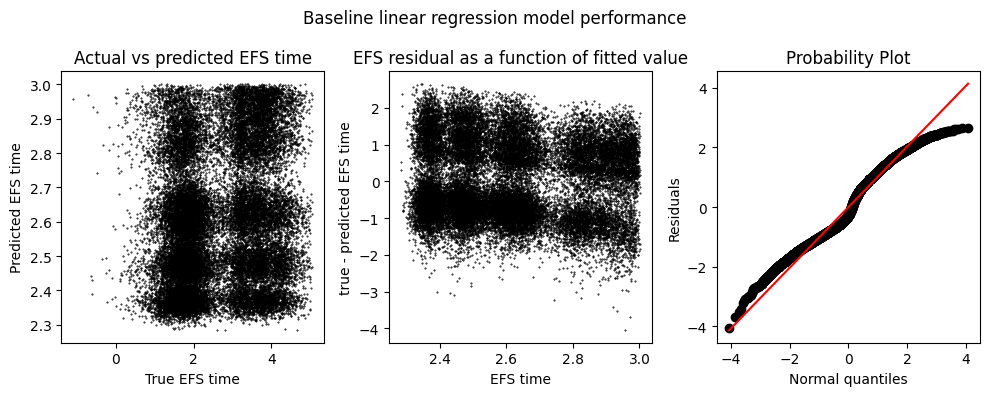

In [66]:
# Instantiate and fit the model
model=LinearRegression()

# Format the features
features['donor_age-x-age']=features['donor_age']*features['age_at_hct']

# Get the labels
efs_time=np.log(training_labels_df['efs_time'])

# Fit the model
model.fit(features,efs_time)

# Make predictions on the test data
predictions=model.predict(features)

# Plot the results
fig, axs=plt.subplots(1,3, figsize=(10,4))
axs=axs.flatten()

fig.suptitle('Baseline linear regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(efs_time, predictions, color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS residual as a function of fitted value')
axs[1].scatter(predictions, efs_time - predictions, color='black', s=0.2)
axs[1].set_xlabel('EFS time')
axs[1].set_ylabel('true - predicted EFS time')

axs[2].set_title('Normal quantile plot')
stats.probplot(efs_time - predictions, plot=axs[2])
axs[2].get_lines()[0].set_markeredgecolor('black')
axs[2].get_lines()[0].set_markerfacecolor('black')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()